In [1]:
# Import all packages needed

from datetime import datetime
from datetime import timedelta

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
from IPython.core.display import HTML
from matplotlib import font_manager as fm

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.graphics as smg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Change global plot font

def make_html(fontname):
    '''
    This function generates fonts
    '''
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in fm.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

plt.rcParams['font.family'] = 'DejaVu Serif'

In [3]:
# Read-in Google Trends data
# Range from April 2004 to April 2024

coffeemaker_df = pd.read_csv('data/coffeemaker.csv', index_col=0)

coffee_df = pd.read_csv('data/coffee.csv', index_col=0)

holiday_df = pd.read_csv('data/holiday.csv', index_col=0)

start_date = datetime(2004,4,1)

end_date = datetime(2024,4,1)

In [4]:
# Clean the three interest datasets

def clean_interest_data(df, start_date, end_date):
    '''
    This function clean the datasets for time series
    Remove first rows
    Change index to datetime
    Change frequency to monthly
    Change values to numeric
    Set the custom start and end range
    '''
    df = df.iloc[1:]
    df.index = pd.to_datetime(df.index)
    df = df.asfreq(pd.infer_freq(df.index))
    df['Category: All categories'] = pd.to_numeric(df['Category: All categories'])
    return df[start_date:end_date]

coffeemaker_df = clean_interest_data(coffeemaker_df, start_date, end_date)

coffee_df = clean_interest_data(coffee_df, start_date, end_date)

holiday_df = clean_interest_data(holiday_df, start_date, end_date)

In [5]:
# Check correlation between coffee, coffeemaker, and holiday search interest

coffee_coffeemaker_corr = np.corrcoef(coffeemaker_df['Category: All categories'],
                                      coffee_df['Category: All categories'])

print(coffee_coffeemaker_corr)

coffee_holiday_corr = np.corrcoef(coffeemaker_df['Category: All categories'],
                                  holiday_df['Category: All categories'])

print(coffee_holiday_corr)

[[1.       0.781292]
 [0.781292 1.      ]]
[[1.        0.6081391]
 [0.6081391 1.       ]]


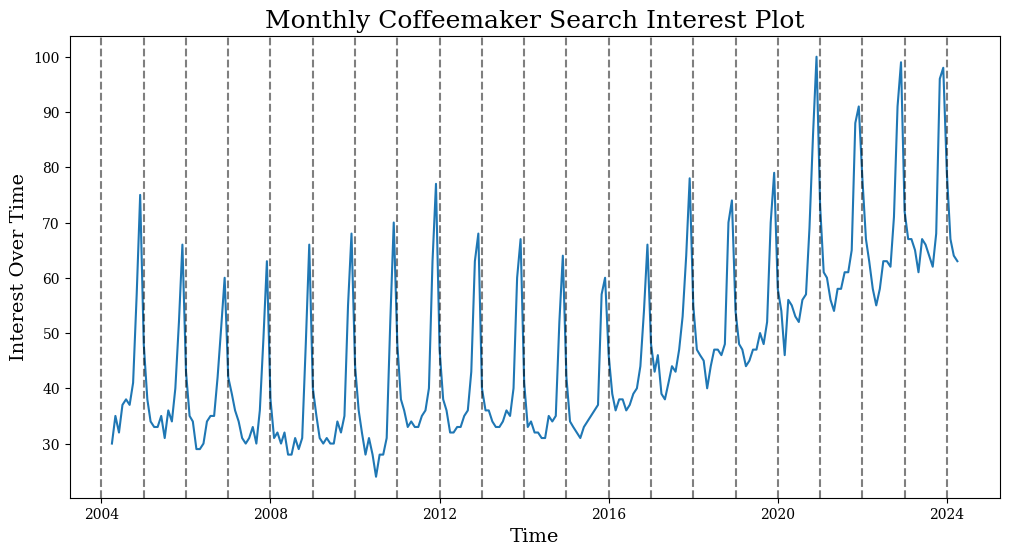

In [6]:
# Monthly coffeemaker search interest plot

plt.figure(figsize=(12,6))
plt.plot(coffeemaker_df)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Interest Over Time', fontsize=14)
plt.title('Monthly Coffeemaker Search Interest Plot', fontsize=18)

for year in range(2004, 2025):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)

plt.show()

In [7]:
# Summary statistics of the three time series

def summary(df):
    '''
    This function calcualtes the summary statistics
    '''
    summary_stats = df.describe().round(3)
    print("Summary Statistics:")
    print(summary_stats)

summary(coffeemaker_df)

summary(coffee_df)

summary(holiday_df)

Summary Statistics:
       Category: All categories
count                   241.000
mean                     46.900
std                      16.104
min                      24.000
25%                      34.000
50%                      42.000
75%                      58.000
max                     100.000
Summary Statistics:
       Category: All categories
count                   241.000
mean                     50.880
std                      17.077
min                      29.000
25%                      35.000
50%                      49.000
75%                      63.000
max                     100.000
Summary Statistics:
       Category: All categories
count                   241.000
mean                      7.701
std                       7.967
min                       3.000
25%                       4.000
50%                       5.000
75%                       7.000
max                     100.000


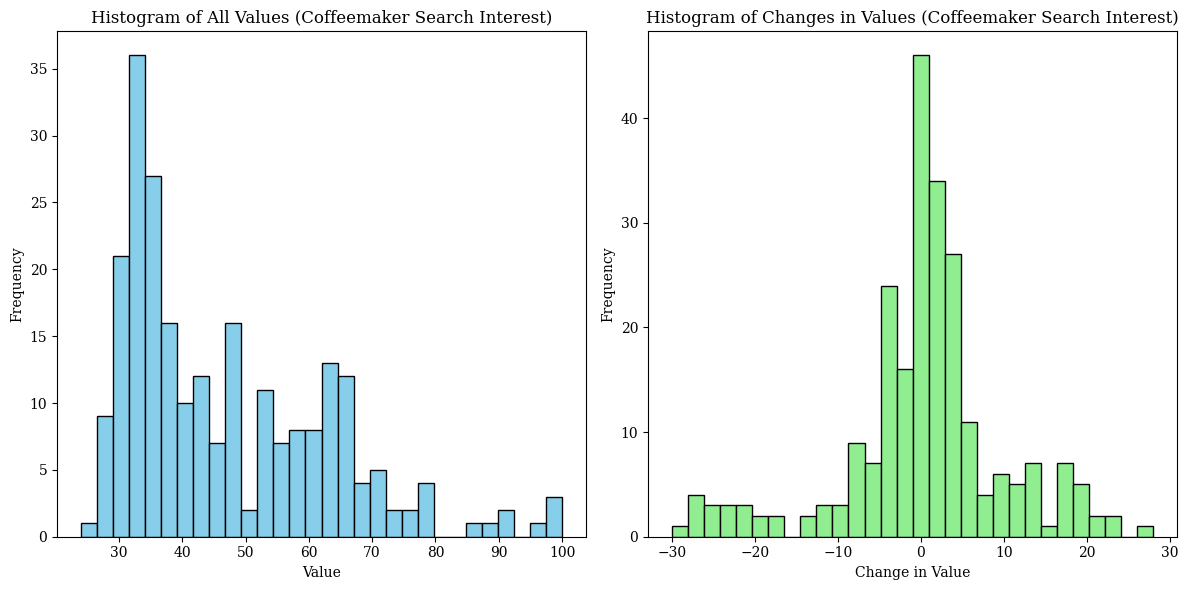

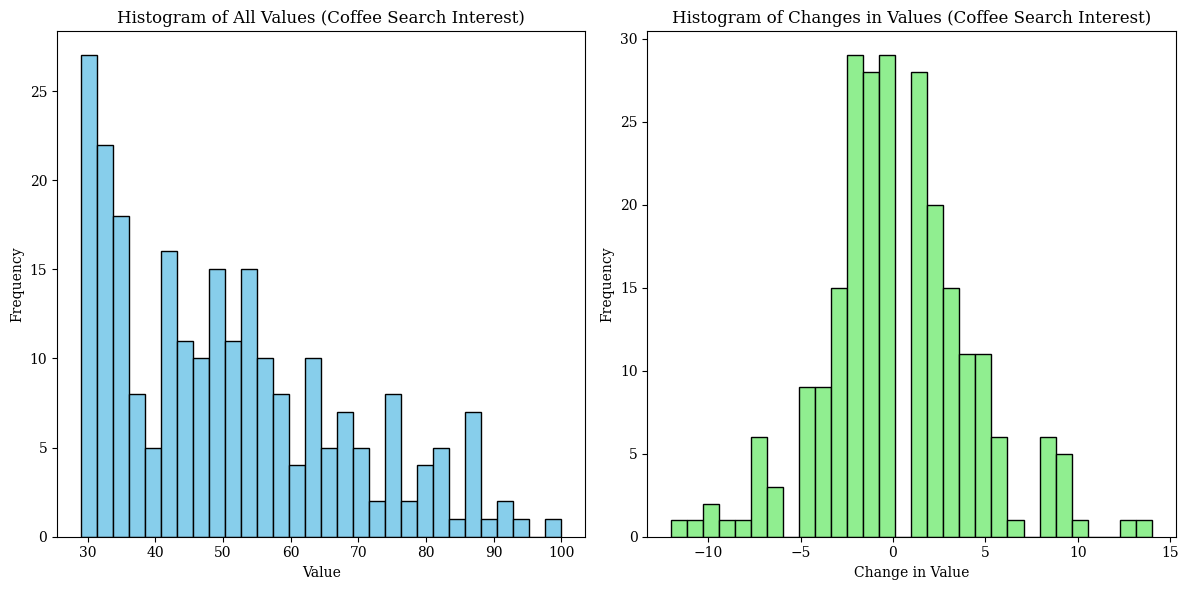

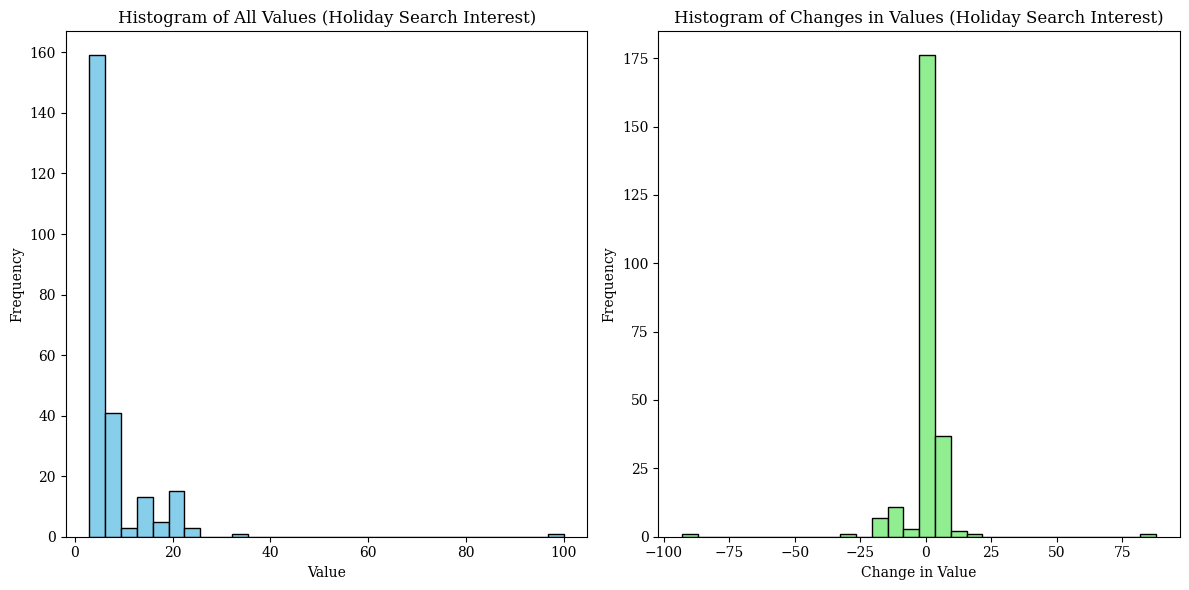

In [8]:
# All histogram plots

def plot_histograms(df, title1='Histogram of All Values',
                    title2='Histogram of Changes in Values'):
    '''
    This function plots the histograms
    Part 1 plots the histogram of all values
    Part 2 plots the histogram of changes in values
    '''
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(df.iloc[:, 0], bins=30, color='skyblue', edgecolor='black')
    plt.title(title1)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    changes = df.diff().dropna()
    plt.subplot(1, 2, 2)
    plt.hist(changes.iloc[:, 0], bins=30, color='lightgreen', edgecolor='black')
    plt.title(title2)
    plt.xlabel('Change in Value')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

plot_histograms(coffeemaker_df,
                title1='Histogram of All Values (Coffeemaker Search Interest)',
                title2='Histogram of Changes in Values (Coffeemaker Search Interest)')

plot_histograms(coffee_df,
                title1='Histogram of All Values (Coffee Search Interest)',
                title2='Histogram of Changes in Values (Coffee Search Interest)')

plot_histograms(holiday_df,
                title1='Histogram of All Values (Holiday Search Interest)',
                title2='Histogram of Changes in Values (Holiday Search Interest)')


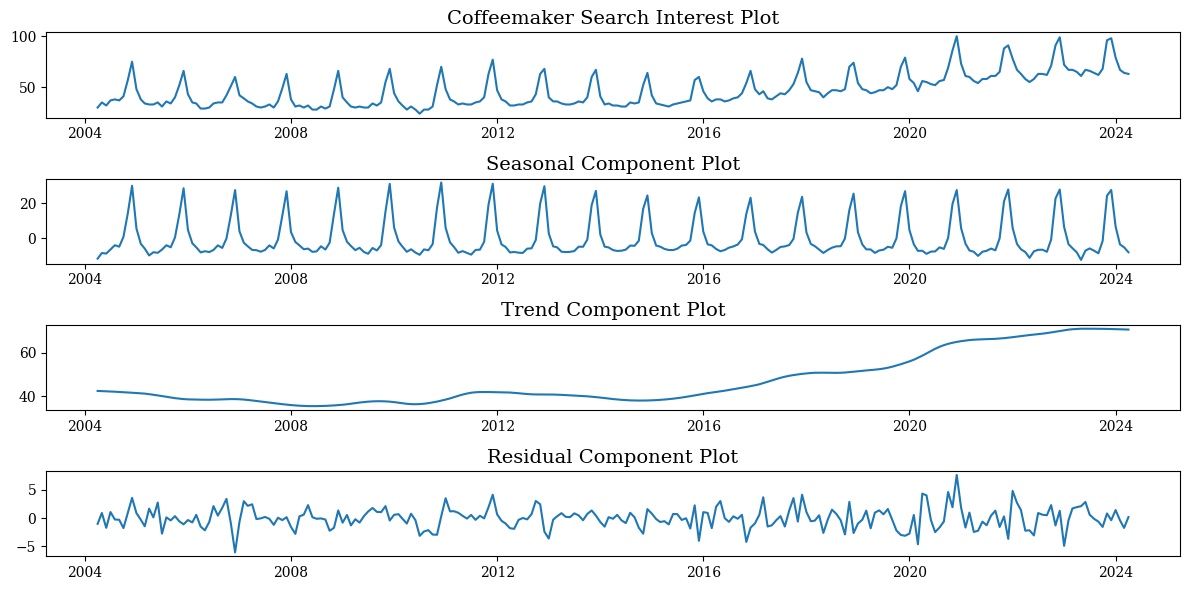

In [9]:
# STL plots
# Plot trend, seasonal, and residual of coffeemaker search interest

stl_coffeemaker = STL(coffeemaker_df).fit()

seasonal_coffeemaker, trend_coffeemaker, resid_coffeemaker = stl_coffeemaker.seasonal, stl_coffeemaker.trend, stl_coffeemaker.resid

stl_coffee = STL(coffee_df).fit()

seasonal_coffee, trend_coffee, resid_coffee = stl_coffee.seasonal, stl_coffee.trend, stl_coffee.resid

plt.figure(figsize=(12,6))

# Original

plt.subplot(4,1,1)
plt.plot(coffeemaker_df)
plt.title('Coffeemaker Search Interest Plot', fontsize=14)

# Seasonality

plt.subplot(4,1,2)
plt.plot(seasonal_coffeemaker)
plt.title('Seasonal Component Plot', fontsize=14)

# Trend

plt.subplot(4,1,3)
plt.plot(trend_coffeemaker)
plt.title('Trend Component Plot', fontsize=14)

# Residual

plt.subplot(4,1,4)
plt.plot(resid_coffeemaker)
plt.title('Residual Component Plot', fontsize=14)

plt.tight_layout()
plt.show()

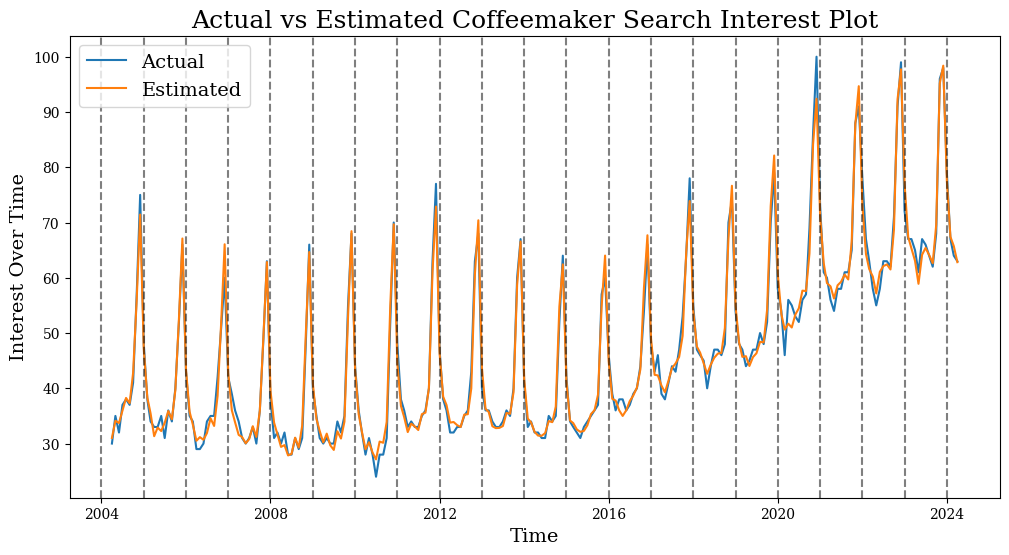

In [10]:
# Anomaly detection part 1
# Actual vs estimated coffeemaker search interest

estimated = trend_coffeemaker + seasonal_coffeemaker

plt.figure(figsize=(12,6))
plt.plot(coffeemaker_df, label='Actual')
plt.plot(estimated, label='Estimated')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Interest Over Time', fontsize=14)
plt.title('Actual vs Estimated Coffeemaker Search Interest Plot', fontsize=18)
plt.legend(fontsize=14)

for year in range(2004, 2025):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)

plt.show()

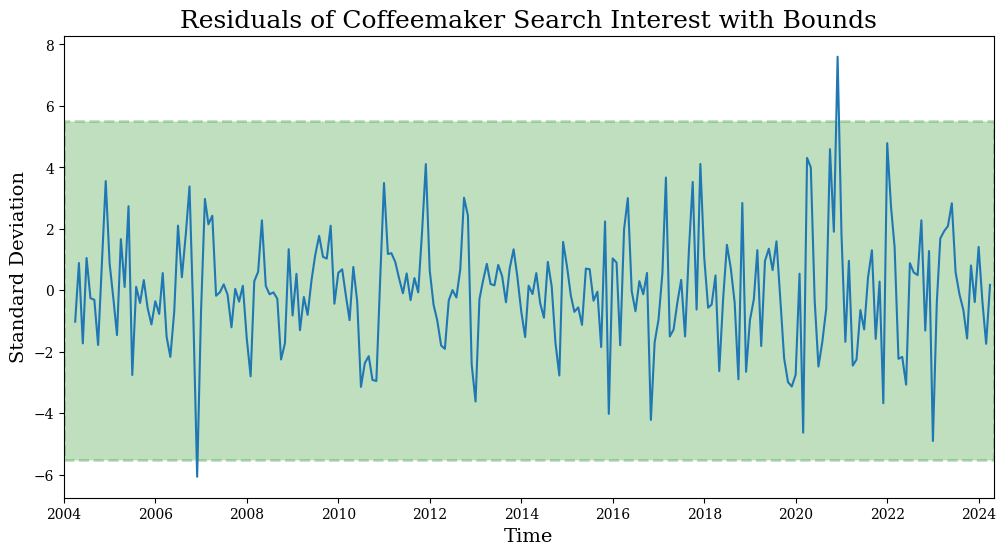

In [11]:
# Anomaly detection part 2
# Residuals of coffeemaker search interest with bounds

resid_mu = resid_coffeemaker.mean()

resid_dev = resid_coffeemaker.std()

lower = resid_mu - 3*resid_dev

upper = resid_mu + 3*resid_dev

plt.figure(figsize=(12,6))
plt.plot(resid_coffeemaker)
plt.fill_between([datetime(2004,1,1), datetime(2024,5,1)], lower, upper, color='g',
                 alpha=0.25, linestyle='--', linewidth=2)
plt.xlabel('Time', fontsize=14)
plt.xlim(datetime(2004,1,1), datetime(2024,5,1))
plt.ylabel('Standard Deviation', fontsize=14)
plt.title('Residuals of Coffeemaker Search Interest with Bounds', fontsize=18)

plt.show()

In [12]:
# Coffeemaker search interest anomalies

anomalies = coffeemaker_df[(resid_coffeemaker < lower) | (resid_coffeemaker > upper)]

anomalies

,Category: All categories
2006-12-01,60
2020-12-01,100


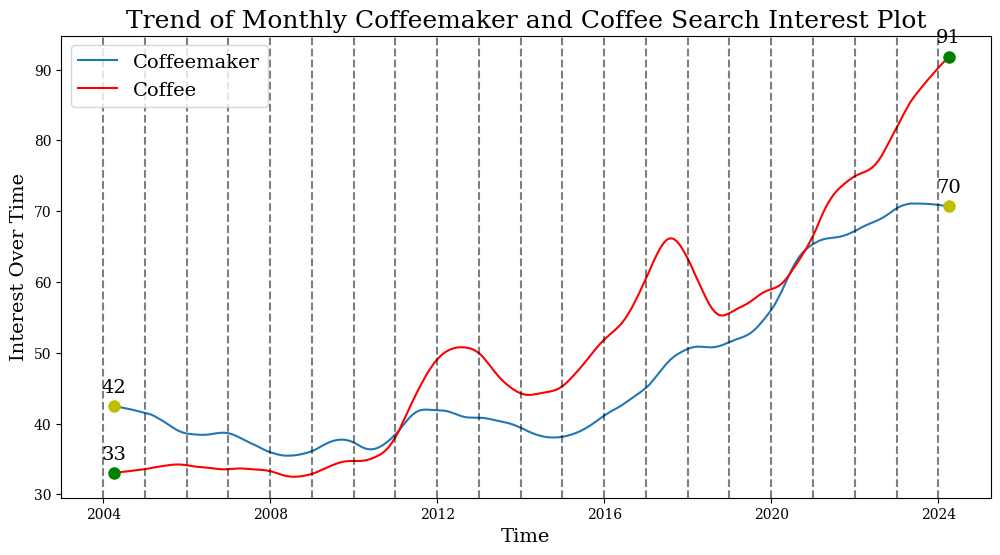

In [13]:
# Trend of coffeemaker vs coffee search interest

plt.figure(figsize=(12, 6))
plt.plot(trend_coffeemaker , label='Coffeemaker')
plt.plot(trend_coffee, 'Red', label='Coffee')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Interest Over Time', fontsize=14)
plt.title('Trend of Monthly Coffeemaker and Coffee Search Interest Plot', fontsize=18)
plt.legend(fontsize=14)

for year in range(2004, 2025):
    plt.axvline(datetime(year, 1, 1), linestyle='--', color='k', alpha=0.5)

# Add start and end points for coffeemaker trend

for entry in [trend_coffeemaker.index[0], trend_coffeemaker.index[-1]]:
    plt.plot(entry, trend_coffeemaker[entry], 'yo', markersize=8)
    plt.annotate(f'{int(trend_coffeemaker[entry])}', 
                 xy=(entry, trend_coffeemaker[entry]), 
                 xytext=(0, 10), 
                 textcoords='offset points',
                 color='black', 
                 fontsize=14,
                 ha='center')

# Add start and end points for coffee trend

for entry in [trend_coffee.index[0], trend_coffee.index[-1]]:
    plt.plot(entry, trend_coffee[entry], 'go', markersize=8)
    plt.annotate(f'{int(trend_coffee[entry])}', 
                 xy=(entry, trend_coffee[entry]), 
                 xytext=(0, 10), 
                 textcoords='offset points',
                 color='black', 
                 fontsize=14,
                 ha='center')

plt.show()

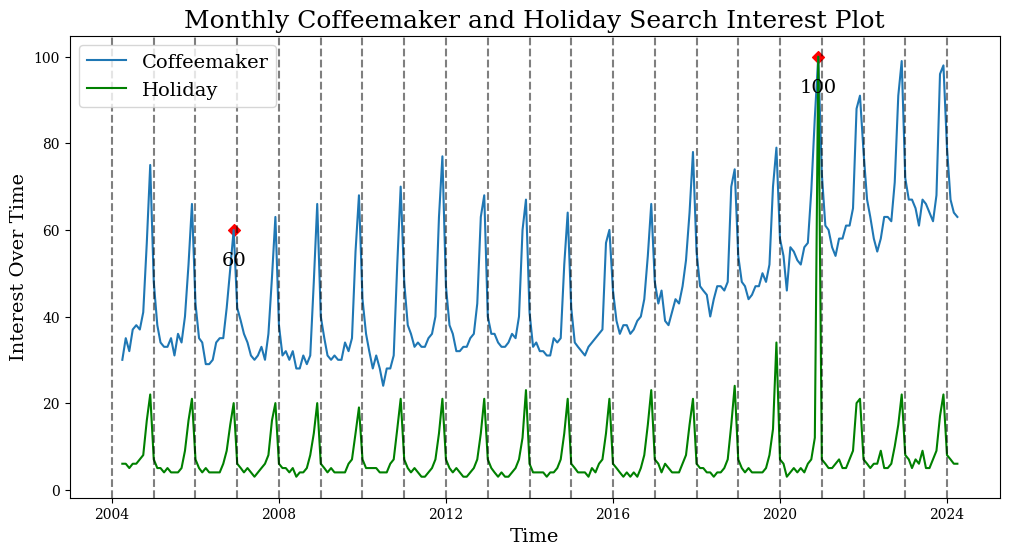

In [14]:
# Coffeemaker vs holiday search interest

plt.figure(figsize=(12,6))
plt.plot(coffeemaker_df)
plt.plot(holiday_df, 'Green')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Interest Over Time', fontsize=14)
plt.title('Monthly Coffeemaker and Holiday Search Interest Plot', fontsize=18)
plt.legend(('Coffeemaker', 'Holiday'), fontsize=14)

for year in range(2004, 2025):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)

# Add anomaly points

for index, row in anomalies.iterrows():
    plt.scatter(index, row['Category: All categories'], color='r', marker='D',
                label='Anomaly Point' if index == anomalies.index[0] else '')
    if index.month < 7:
        plt.text(index, row['Category: All categories'] + 5,
                 f'{row["Category: All categories"]:.0f}', ha='center', va='bottom', fontsize=14)
    else:
        plt.text(index, row['Category: All categories'] - 5,
                 f'{row["Category: All categories"]:.0f}', ha='center', va='top', fontsize=14)

plt.show()

In [15]:
# Check for stationarity in coffeemaker search interest

def check_stationarity(df):
    '''
    This function checks the stationarity of the time series with ADF
    If the result is smaller and equal to 0.05 -> print stationary
    If the result is bigger than 0.05 -> print non-stationary
    '''
    for column in df.columns:
        result = adfuller(df[column])
        print(f'Column: {column}')
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
        
        if result[1] <= 0.05:
            print(f'{column} is stationary')
        
        else:
            print(f'{column} is non-stationary')
            
check_stationarity(coffeemaker_df)

Column: Category: All categories
ADF Statistic: 0.941819
p-value: 0.993613
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574
Category: All categories is non-stationary


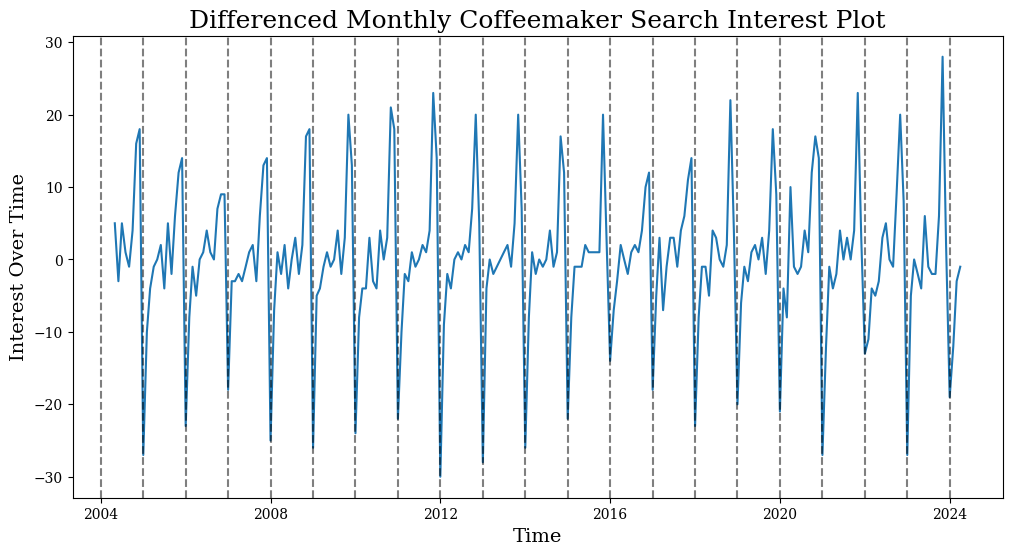

In [16]:
# First-order differencing coffeemaker search interest data

diff_coffeemaker_df = coffeemaker_df.diff()[1:]

plt.figure(figsize=(12,6))
plt.plot(diff_coffeemaker_df)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Interest Over Time', fontsize=14)
plt.title('Differenced Monthly Coffeemaker Search Interest Plot', fontsize=18)

for year in range(2004, 2025):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)

plt.show()

In [17]:
# coffeemaker interest data is stationary now

check_stationarity(diff_coffeemaker_df)

Column: Category: All categories
ADF Statistic: -5.003343
p-value: 0.000022
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574
Category: All categories is stationary


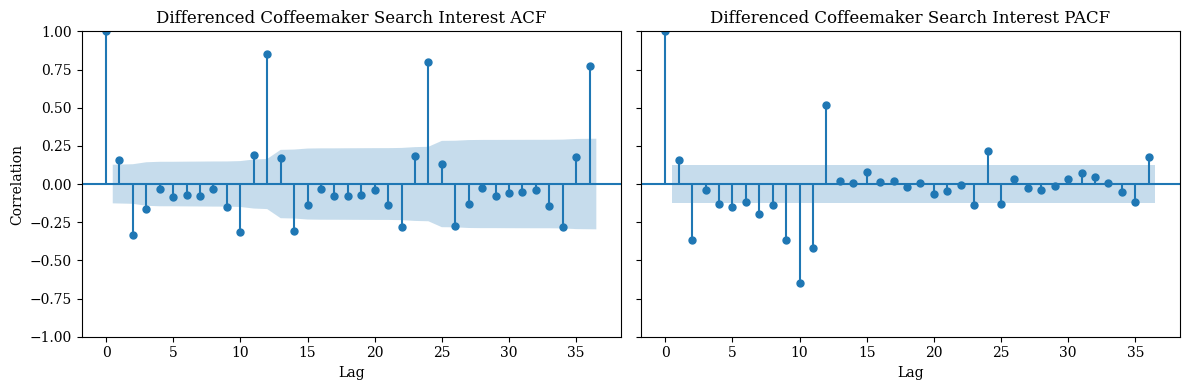

In [18]:
# Differenced coffeemaker search interest ACF and PACF Plot

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
smg.tsaplots.plot_acf(diff_coffeemaker_df, lags=36, ax=axes[0],
                      title='Differenced Coffeemaker Search Interest ACF', alpha=0.05)
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Correlation')
smg.tsaplots.plot_pacf(diff_coffeemaker_df, lags=36, ax=axes[1],
                       title='Differenced Coffeemaker Search Interest PACF', alpha=0.05)
axes[1].set_xlabel('Lag')

plt.tight_layout()
plt.show()

In [19]:
# Split data into training and testing
# 80% training and 20% testing

train_end = datetime(2020,4,1)

test_end = datetime(2024,4,1)

train_coffeemaker_df = coffeemaker_df[:train_end]

test_coffeemaker_df = coffeemaker_df[train_end + timedelta(days=1):test_end]

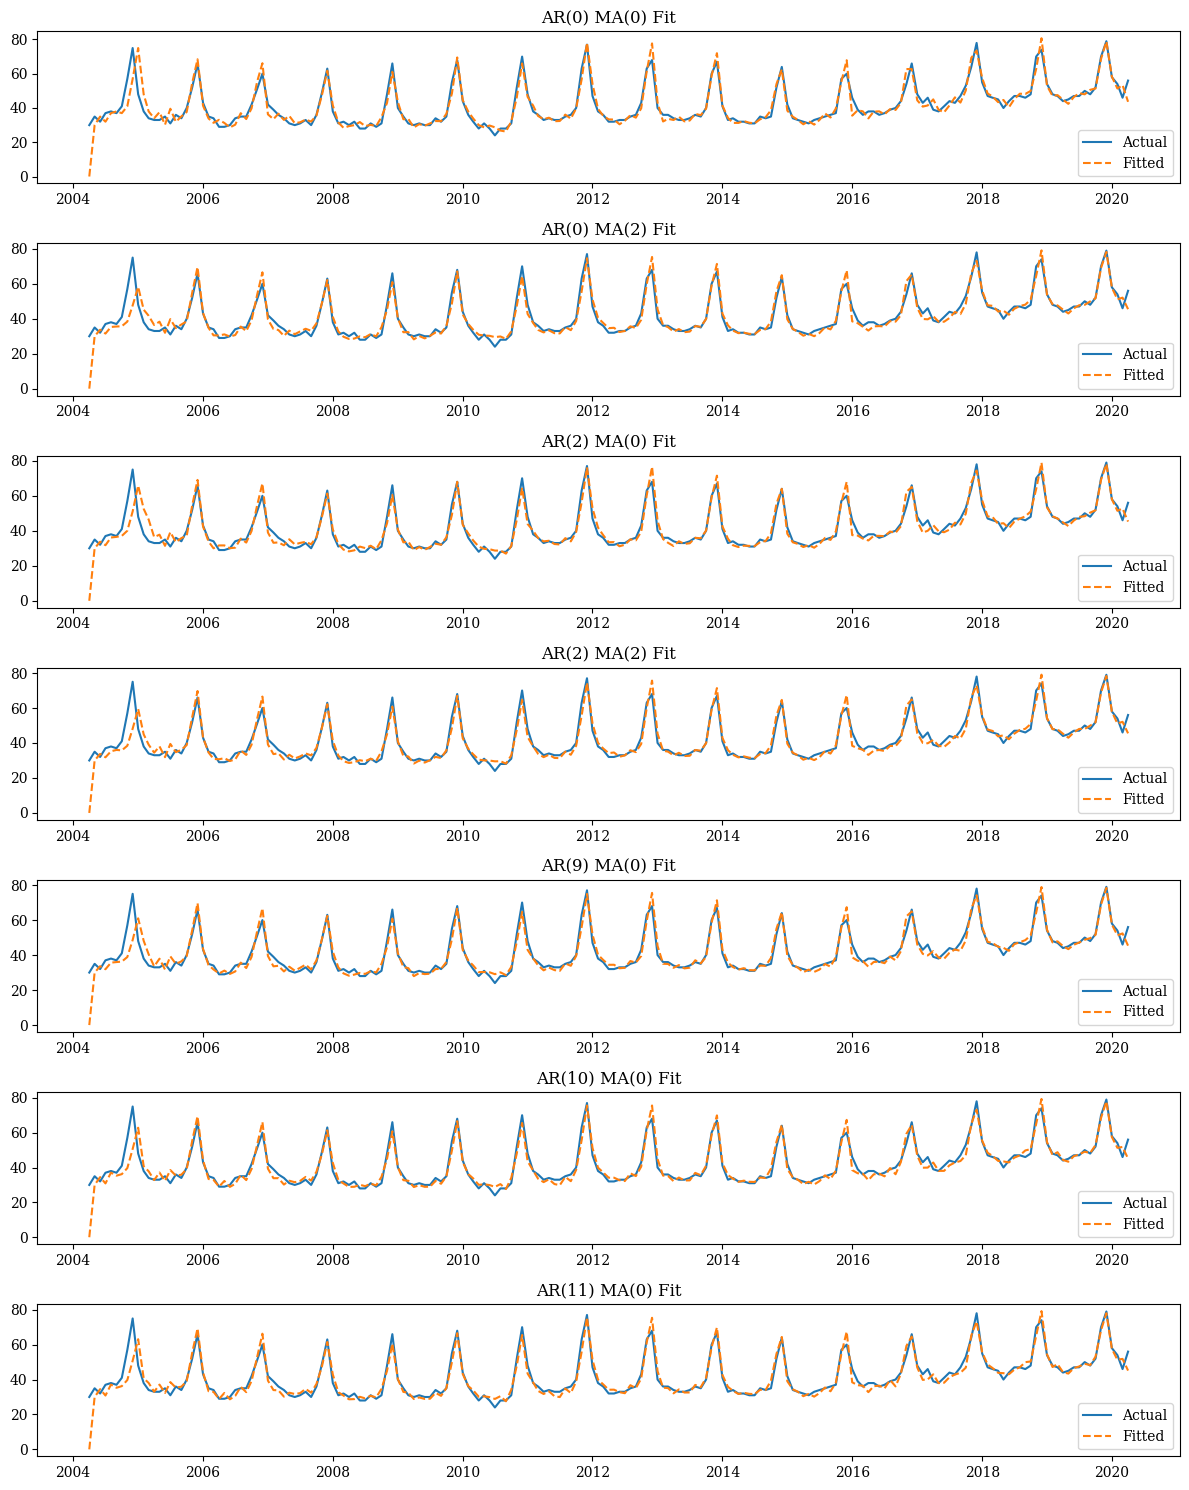

In [20]:
# Test model fit with different AR and MA order

ar_orders = [0, 0, 2, 2, 9, 10, 11]

ma_orders = [0, 2, 0, 2, 0, 0, 0]

model_fit_dict = {}  

fig, axes = plt.subplots(7, 1, figsize=(12, 15)) 

for idx, (ar_order, ma_order) in enumerate(zip(ar_orders, ma_orders)):
    model = SARIMAX(train_coffeemaker_df, order=(ar_order, 1, ma_order),
                    seasonal_order=(1, 0, 1, 12))
    model_fit = model.fit(disp=0)
    model_fit_dict[(ar_order, ma_order)] = model_fit
    axes[idx].plot(train_coffeemaker_df, label='Actual')
    axes[idx].plot(model_fit.fittedvalues, label='Fitted', linestyle='--')
    axes[idx].set_title(f'AR({ar_order}) MA({ma_order}) Fit', fontsize=12)
    axes[idx].legend()

plt.tight_layout()
plt.show()

In [22]:
# Compare AIC

for ar_order, ma_order in zip(ar_orders, ma_orders):
    print(f"AIC for AR({ar_order}) MA({ma_order}): {model_fit_dict[(ar_order, ma_order)].aic}")

# Compare BIC

for ar_order, ma_order in zip(ar_orders, ma_orders):
    print(f"BIC for AR({ar_order}) MA({ma_order}): {model_fit_dict[(ar_order, ma_order)].bic}")

AIC for AR(0) MA(0): 1030.9406919261419
AIC for AR(0) MA(2): 999.6220972600934
AIC for AR(2) MA(0): 1013.4607856112405
AIC for AR(2) MA(2): 1001.9585134619283
AIC for AR(9) MA(0): 1010.1780547822175
AIC for AR(10) MA(0): 1001.8401008263266
AIC for AR(11) MA(0): 1003.606289518502
BIC for AR(0) MA(0): 1040.7131780422253
BIC for AR(0) MA(2): 1015.9095741202323
BIC for AR(2) MA(0): 1029.7482624713793
BIC for AR(2) MA(2): 1024.7609810661227
BIC for AR(9) MA(0): 1049.267999246551
BIC for AR(10) MA(0): 1044.1875406626878
BIC for AR(11) MA(0): 1049.2112247268908


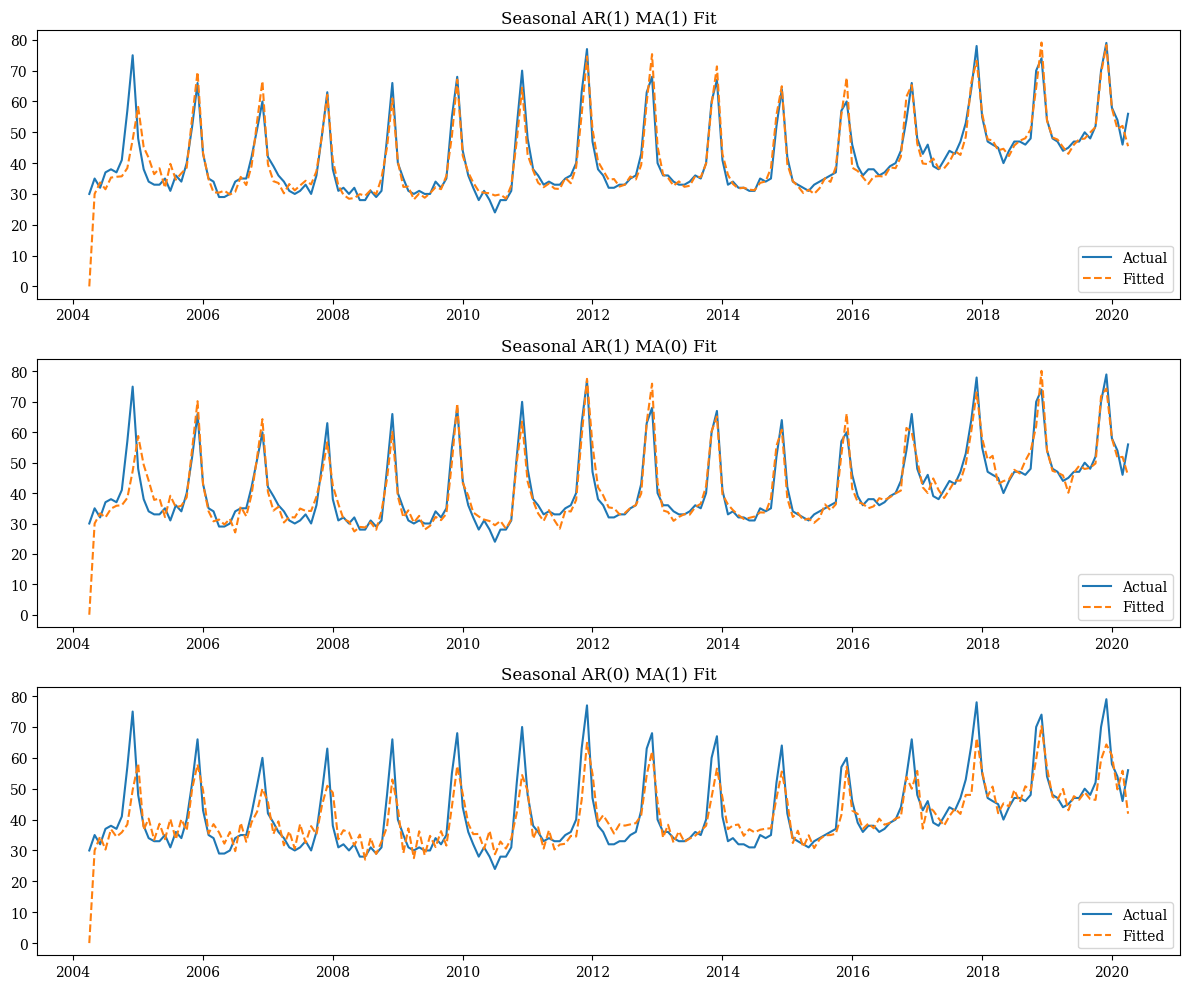

In [23]:
# Test model fit with different seasonal AR and MA order

seasonal_ar_orders = [1, 1, 0]

seasonal_ma_orders = [1, 0, 1]

model_fit_dict = {}  

fig, axes = plt.subplots(3, 1, figsize=(12, 10)) 

for idx, (seasonal_ar_order, seasonal_ma_order) in enumerate(zip(seasonal_ar_orders, seasonal_ma_orders)):
    model = SARIMAX(train_coffeemaker_df, order=(0, 1, 2),
                    seasonal_order=(seasonal_ar_order, 0, seasonal_ma_order, 12))
    model_fit = model.fit(disp=0)
    model_fit_dict[(seasonal_ar_order, seasonal_ma_order)] = model_fit
    axes[idx].plot(train_coffeemaker_df, label='Actual')
    axes[idx].plot(model_fit.fittedvalues, label='Fitted', linestyle='--')
    axes[idx].set_title(f'Seasonal AR({seasonal_ar_order}) MA({seasonal_ma_order}) Fit', fontsize=12)
    axes[idx].legend()

plt.tight_layout()
plt.show()

In [24]:
# Compare seasonal parameter AIC

for seasonal_ar_order, seasonal_ma_order in zip(seasonal_ar_orders, seasonal_ma_orders):
    print(f"AIC for seasonal AR({seasonal_ar_order}) MA({seasonal_ma_order}): {model_fit_dict[(seasonal_ar_order, seasonal_ma_order)].aic}")

# Compare seasonal parameter BIC

for seasonal_ar_order, seasonal_ma_order in zip(seasonal_ar_orders, seasonal_ma_orders):
    print(f"AIC for seasonal AR({seasonal_ar_order}) MA({seasonal_ma_order}): {model_fit_dict[(seasonal_ar_order, seasonal_ma_order)].bic}")

AIC for seasonal AR(1) MA(1): 999.6220972600934
AIC for seasonal AR(1) MA(0): 1036.7383119482342
AIC for seasonal AR(0) MA(1): 1245.594070065338
AIC for seasonal AR(1) MA(1): 1015.9095741202323
AIC for seasonal AR(1) MA(0): 1049.7682934363454
AIC for seasonal AR(0) MA(1): 1258.6240515534491


In [25]:
# Fit of SARIMA model
# (0, 1, 2) (1, 0, 1, 12)

my_order = (0, 1, 2)

my_seasonal_order = (1, 0, 1, 12)

sarima_model = SARIMAX(train_coffeemaker_df, order=my_order, seasonal_order=my_seasonal_order)

sarima_model_fit = sarima_model.fit()

sarima_model_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.24697D+00    |proj g|=  9.32004D-02

At iterate    5    f=  2.63593D+00    |proj g|=  1.71292D-01

At iterate   10    f=  2.57754D+00    |proj g|=  8.34691D-03

At iterate   15    f=  2.56451D+00    |proj g|=  1.58799D-02

At iterate   20    f=  2.56379D+00    |proj g|=  1.35345D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     28      1     0     0   5.066D-06   2.564D+00
  F =   2.5637878167359931     

CONVERG

 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:             Category: All categories   No. Observations:                  193
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -494.811
Date:                              Mon, 01 Jul 2024   AIC                            999.622
Time:                                      19:17:42   BIC                           1015.910
Sample:                                  04-01-2004   HQIC                          1006.219
                                       - 04-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4374      0.066     -6.589      0.000      -0.567      -0.307
ma.L2         -0.2662      0.066     -4.034      0.000      -0.396      -0.137
ar.S.L12       0.9956      0.002    467.267      0.000       0.991       1.000
ma.S.L12      -0.7085      0.063    -11.313      0.000      -0.831      -0.586
sigma2         8.3822      0.771     10.875      0.000       6.871       9.893
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                10.02
Prob(Q):                              0.73   Prob(JB):                         0.01
Heteroskedasticity (H):               1.40   Skew:                             0.10
Prob(H) (two-sided):                  0.18   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
# Calculate Mean Absolute Error (MAE)

mae = mean_absolute_error(train_coffeemaker_df, sarima_model_fit.fittedvalues)

# Calculate Mean Squared Error (MSE)

mse = mean_squared_error(train_coffeemaker_df, sarima_model_fit.fittedvalues)

# Calculate Root Mean Squared Error (RMSE)

rmse = np.sqrt(mse)

print("Training Root Mean Squared Error (RMSE):", rmse)

Training Root Mean Squared Error (RMSE): 4.482367782917767


In [27]:
# 4 year predictions of SARIMA model
# (0, 1, 2) (1, 0, 1, 12)

predictions = sarima_model_fit.forecast(len(test_coffeemaker_df))

predictions = pd.Series(predictions, index=test_coffeemaker_df.index)

residuals = test_coffeemaker_df['Category: All categories'] - predictions

print('SARIMA Model Mean Absolute Percent Error:',
      round(np.mean(abs(residuals/test_coffeemaker_df['Category: All categories'])), 4))

print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

SARIMA Model Mean Absolute Percent Error: 0.0717
Root Mean Squared Error: 6.631269998570665


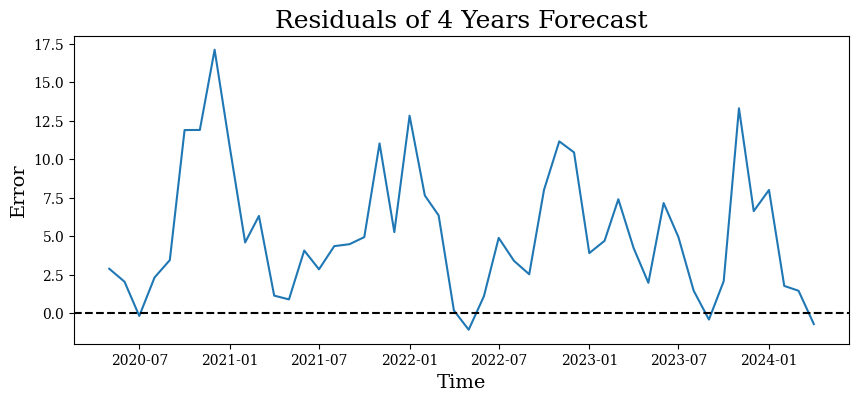

In [28]:
# Residuals of 4 years predictions
# (0, 1, 2) (1, 0, 1, 12)

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title('Residuals of 4 Years Forecast', fontsize=18)

plt.show()

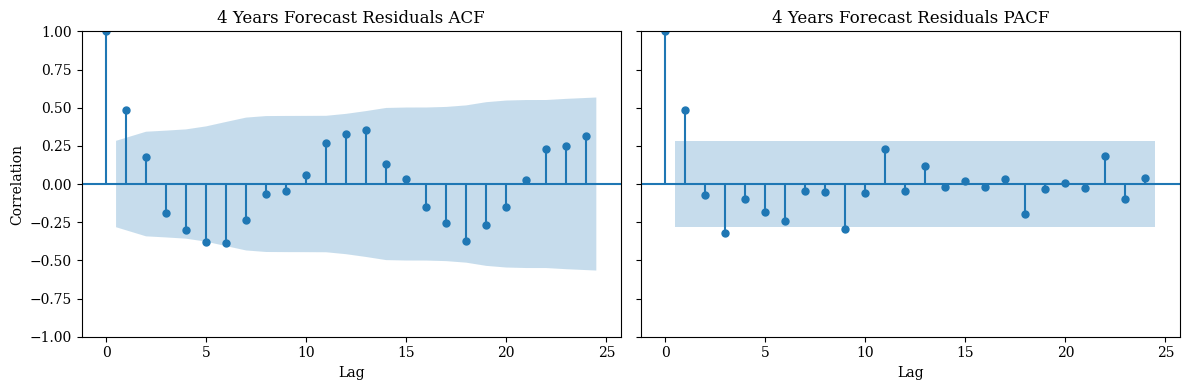

In [29]:
# Residuals of 4 years predictions ACF and PACF
# (0, 1, 2) (1, 0, 1, 12)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

smg.tsaplots.plot_acf(residuals, lags=24, ax=axes[0],
                      title='4 Years Forecast Residuals ACF', alpha=0.05)
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Correlation')
smg.tsaplots.plot_pacf(residuals, lags=24, ax=axes[1],
                       title='4 Years Forecast Residuals PACF', alpha=0.05)
axes[1].set_xlabel('Lag')

plt.tight_layout()
plt.show()

In [30]:
# Ljung-box test of 4 years residuals

residual_autocorrelation_test = acorr_ljungbox(residuals)

residual_autocorrelation_test

,lb_stat,lb_pvalue
1,11.904462,0.000560
2,13.536034,0.001150
3,15.444562,0.001474
4,20.358952,0.000424
5,28.317103,0.000032
6,36.860947,0.000002
7,40.103766,0.000001
8,40.365941,0.000003
9,40.489201,0.000006


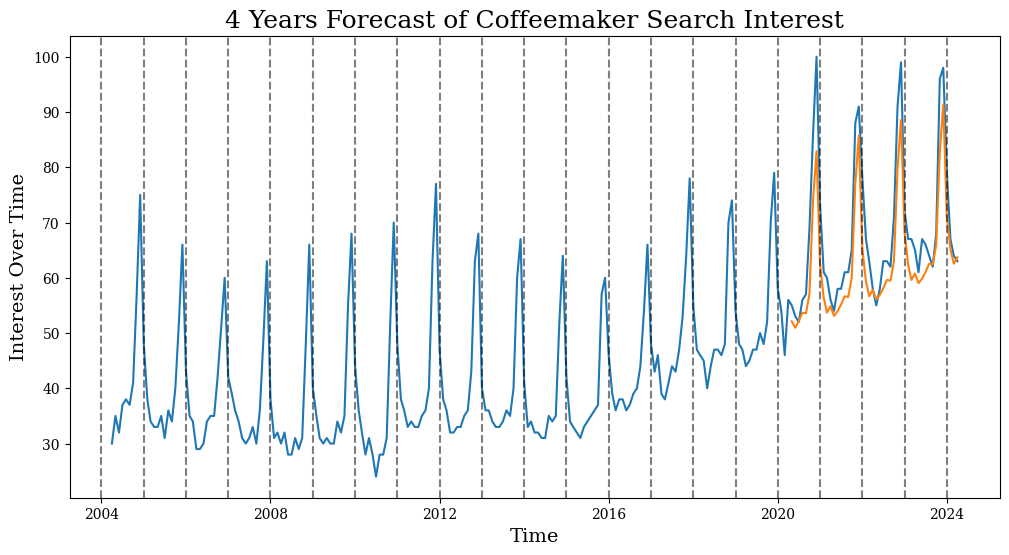

In [31]:
# 4 Years predictions of coffeemaker search interest

plt.figure(figsize=(12,6))
plt.plot(coffeemaker_df)
plt.plot(predictions)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Interest Over Time', fontsize=14)
plt.title('4 Years Forecast of Coffeemaker Search Interest', fontsize=18)

for year in range(2004, 2025):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)

plt.show()

In [32]:
# Rolling model fit of coffeemaker search interest

rolling_predictions = test_coffeemaker_df.copy()

for end_date in test_coffeemaker_df.index:
    train = coffeemaker_df[:end_date - timedelta(days=1)]
    model = SARIMAX(train, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit(disp=False)
    pred = model_fit.forecast()
    rolling_predictions[end_date] = pred

model_fit.summary()

/Users/williamwang/coffeemaker_timeSeries_project/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/williamwang/coffeemaker_timeSeries_project/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/williamwang/coffeemaker_timeSeries_project/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/williamwang/coffeemaker_timeSeries_project/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary st

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:             Category: All categories   No. Observations:                  240
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -627.421
Date:                              Mon, 01 Jul 2024   AIC                           1264.841
Time:                                      19:18:13   BIC                           1282.224
Sample:                                  04-01-2004   HQIC                          1271.846
                                       - 03-01-2024                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4312      0.056     -7.697      0.000      -0.541      -0.321
ma.L2         -0.2384      0.057     -4.174      0.000      -0.350      -0.126
ar.S.L12       0.9975      0.001    750.632      0.000       0.995       1.000
ma.S.L12      -0.7771      0.046    -16.851      0.000      -0.868      -0.687
sigma2         9.4666      0.785     12.059      0.000       7.928      11.005
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                11.79
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               1.63   Skew:                             0.30
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
# Rolling predictions of coffeemaker search interest

rolling_predictions = rolling_predictions.iloc[:, 1:]

diagonal_values = [rolling_predictions.iloc[i, i] for i in range(min(rolling_predictions.shape))]

diagonal_df = pd.DataFrame(diagonal_values, columns=["Diagonal"])

diagonal_df.index = pd.to_datetime(rolling_predictions.columns)

rolling_residuals = test_coffeemaker_df['Category: All categories'] - diagonal_df['Diagonal']

print('SARIMA Model Mean Absolute Percent Error:',
      round(np.mean(abs(rolling_residuals/test_coffeemaker_df['Category: All categories'])), 4))

print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

SARIMA Model Mean Absolute Percent Error: 0.0435
Root Mean Squared Error: 3.8524716725757284


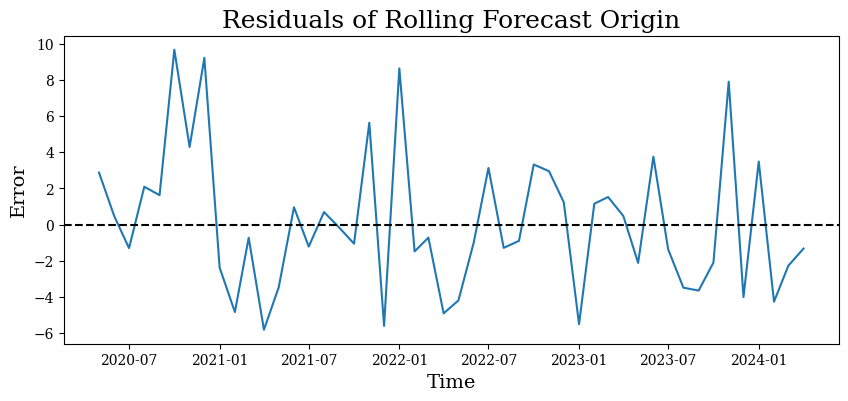

In [34]:
# Residuals of rolling predictions

plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title('Residuals of Rolling Forecast Origin', fontsize=18)

plt.show()

In [35]:
# Compare the mean of the different residuals

print(np.mean(residuals))

print(np.mean(rolling_residuals))

5.150307555037006
0.08382689729178505


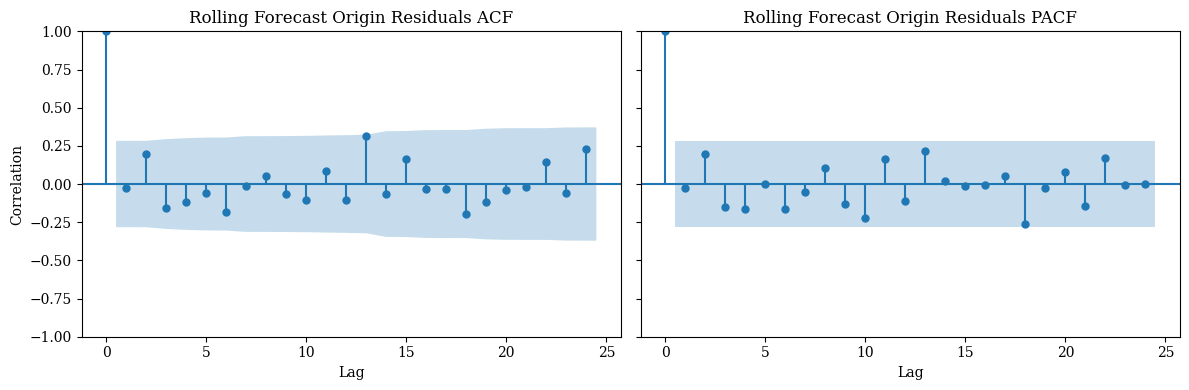

In [36]:
# Residuals of rolling predictions ACF and PACF

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
smg.tsaplots.plot_acf(rolling_residuals, lags=24, ax=axes[0],
                      title='Rolling Forecast Origin Residuals ACF', alpha=0.05) 
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Correlation')
smg.tsaplots.plot_pacf(rolling_residuals, lags=24, ax=axes[1],
                       title='Rolling Forecast Origin Residuals PACF', alpha=0.05)
axes[1].set_xlabel('Lag')

plt.tight_layout()
plt.show()

In [37]:
# Ljung-box test of rolling residuals

rolling_residual_autocorrelation_test = acorr_ljungbox(rolling_residuals)
rolling_residual_autocorrelation_test

,lb_stat,lb_pvalue
1,0.034828,0.851957
2,2.084085,0.352733
3,3.383903,0.336135
4,4.108524,0.391518
5,4.284150,0.509272
6,6.211539,0.399916
7,6.218265,0.514508
8,6.373141,0.605511
9,6.635479,0.675012


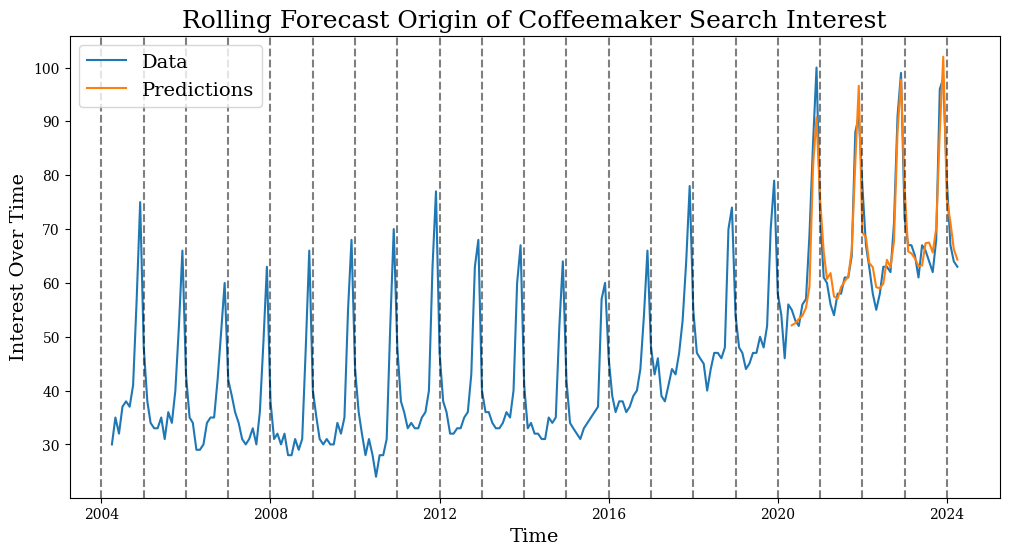

In [38]:
# Rolling predictions of monthly coffeemaker search interest

plt.figure(figsize=(12,6))
plt.plot(coffeemaker_df)
plt.plot(diagonal_df)
plt.legend(('Data', 'Predictions'), fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Interest Over Time', fontsize=14)
plt.title('Rolling Forecast Origin of Coffeemaker Search Interest', fontsize=18)

for year in range(2004, 2025):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)

plt.show()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29777D+00    |proj g|=  8.94582D-02

At iterate    5    f=  2.76837D+00    |proj g|=  9.80149D-02

At iterate   10    f=  2.61230D+00    |proj g|=  1.69607D-03

At iterate   15    f=  2.61229D+00    |proj g|=  4.83523D-04

At iterate   20    f=  2.61227D+00    |proj g|=  3.10512D-03

At iterate   25    f=  2.61226D+00    |proj g|=  2.72077D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     31      1     0     0   

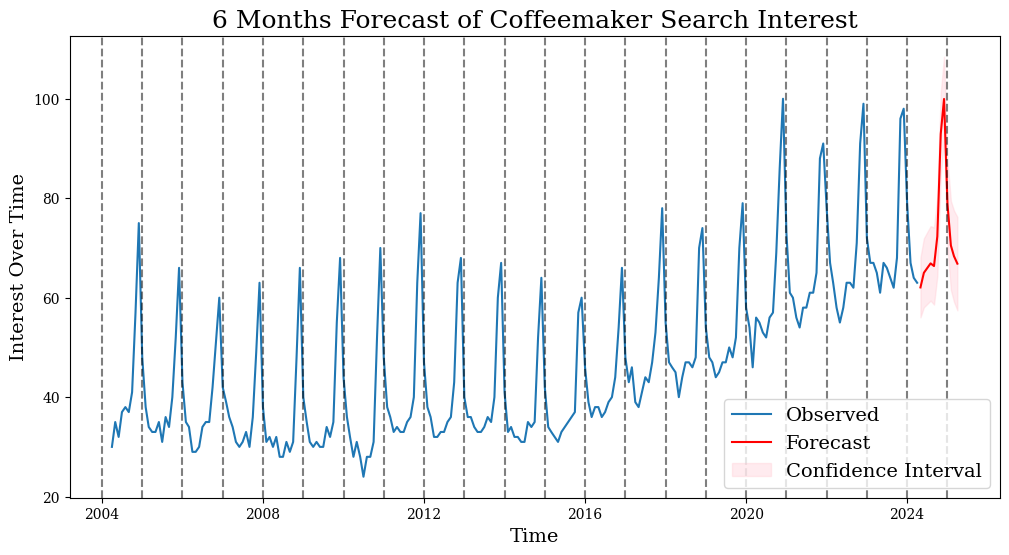

In [39]:
# 6 month forecasting

final_model = SARIMAX(coffeemaker_df, order=my_order, seasonal_order=my_seasonal_order) 

final_model_fit = final_model.fit()

forecast = final_model_fit.forecast(steps=12)

forecast_ci = final_model_fit.get_forecast(steps=12).conf_int()

plt.figure(figsize=(12, 6))
plt.plot(coffeemaker_df, label='Observed')
plt.plot(forecast, color='red', label='Forecast')
plt.fill_between(forecast.index, forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Interest Over Time', fontsize=14)
plt.title('6 Months Forecast of Coffeemaker Search Interest', fontsize=18)
plt.legend(fontsize=14)

for year in range(2004, 2026):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)

plt.show()